# Elman_network.ipynb

Using an Elman network to learn to trace circles and figure eights.

In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
# import lovely_tensors as lt
# lt.monkey_patch()
%cd ./data/

/home/z/OIST Dropbox/Sergio Verduzco/code/python/pytorch/deep_explorations/rnn/data


/home/z/environments/jax/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cuda:0


In [4]:
# Load training data
fname = 'switch_circle5_triangle5_1.pkl'
with open(fname, 'rb') as f:
    coordinates = pickle.load(f)

Coordinates shape: torch.Size([986, 2])


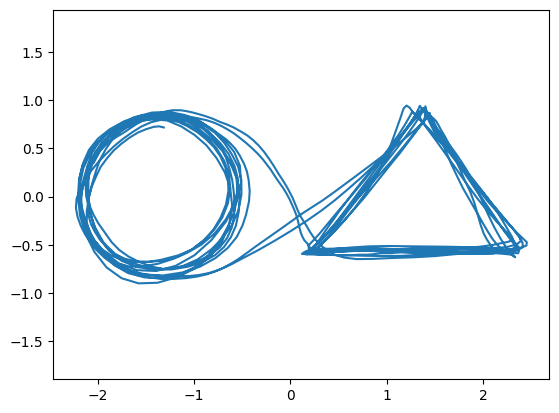

In [5]:
# plot the loaded array
fig = plt.figure()
plt.axis('equal')
plt.plot(coordinates[:,0], coordinates[:,1])

coordinates = torch.tensor(coordinates, dtype=torch.float32)
print(f"Coordinates shape: {coordinates.shape}")

## The Elman RNN

In [6]:
# Create the network, the optimizer, and the loss function
input_size = 2  # this shouldn't change
hidden_size = 256
nonlinearity = 'tanh'  # tanh or relu
lr = 3e-4  # learning rate
all_generated = []

torch.manual_seed(345)

class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, nonlinearity):
        super(ElmanRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          nonlinearity=nonlinearity,
                          num_layers=1,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x, h0=None):
        if h0 is None:
            h0 =  torch.zeros((1, hidden_size))
        out, h = self.rnn(x, h0)
        return self.fc(out), h

rnn = ElmanRNN(input_size, hidden_size, nonlinearity)

optim = torch.optim.Adam(rnn.parameters(), lr=lr)

loss = nn.MSELoss(reduction='mean')

In [22]:
# training loop
n_epochs = 1000  # number of epochs

for epoch in range(n_epochs):
    optim.zero_grad()
    out, _  = rnn(coordinates[:-1])
    error = loss(out, coordinates[1:])
    error.backward()
    optim.step()
    if epoch % 20 == 0:
        print(f"Error at epoch {epoch} = {error}")

Error at epoch 0 = 0.0007256335811689496
Error at epoch 20 = 0.0007178405066952109
Error at epoch 40 = 0.0007101576775312424
Error at epoch 60 = 0.0007025800878182054
Error at epoch 80 = 0.0006951043615117669
Error at epoch 100 = 0.0006877278792671859
Error at epoch 120 = 0.0007455674931406975
Error at epoch 140 = 0.0007301208679564297
Error at epoch 160 = 0.0006891717785038054
Error at epoch 180 = 0.0006655576871708035
Error at epoch 200 = 0.0006582856294699013
Error at epoch 220 = 0.0006512491381727159
Error at epoch 240 = 0.000644573534373194
Error at epoch 260 = 0.000638077559415251
Error at epoch 280 = 0.0006317017832770944
Error at epoch 300 = 0.0006254240870475769
Error at epoch 320 = 0.0006192326545715332
Error at epoch 340 = 0.0006131219561211765
Error at epoch 360 = 0.0006070871604606509
Error at epoch 380 = 0.0006011257064528763
Error at epoch 400 = 0.00059523741947487
Error at epoch 420 = 0.0005894220084883273
Error at epoch 440 = 0.0005836801137775183
Error at epoch 460 = 

In [29]:
# Generate a trajectory
n_points = 1000
coordinate = torch.tensor([-1, 1], dtype=torch.float32)
#coordinate = coordinates[0]
coordinate = coordinate.unsqueeze(dim=0)

def generate_trajectory(init_coordinate, n_points):
    gen_coordinates = np.empty((n_points, 2))
    coordinate = init_coordinate
    h = torch.zeros((1, hidden_size))
    with torch.no_grad():
        for point_idx in range(n_points):
            coordinate, h = rnn(coordinate, h)
            gen_coordinates[point_idx, :] = coordinate.detach().numpy()
    return gen_coordinates

gen_coordinates = generate_trajectory(coordinate, n_points)
all_generated.append(gen_coordinates)

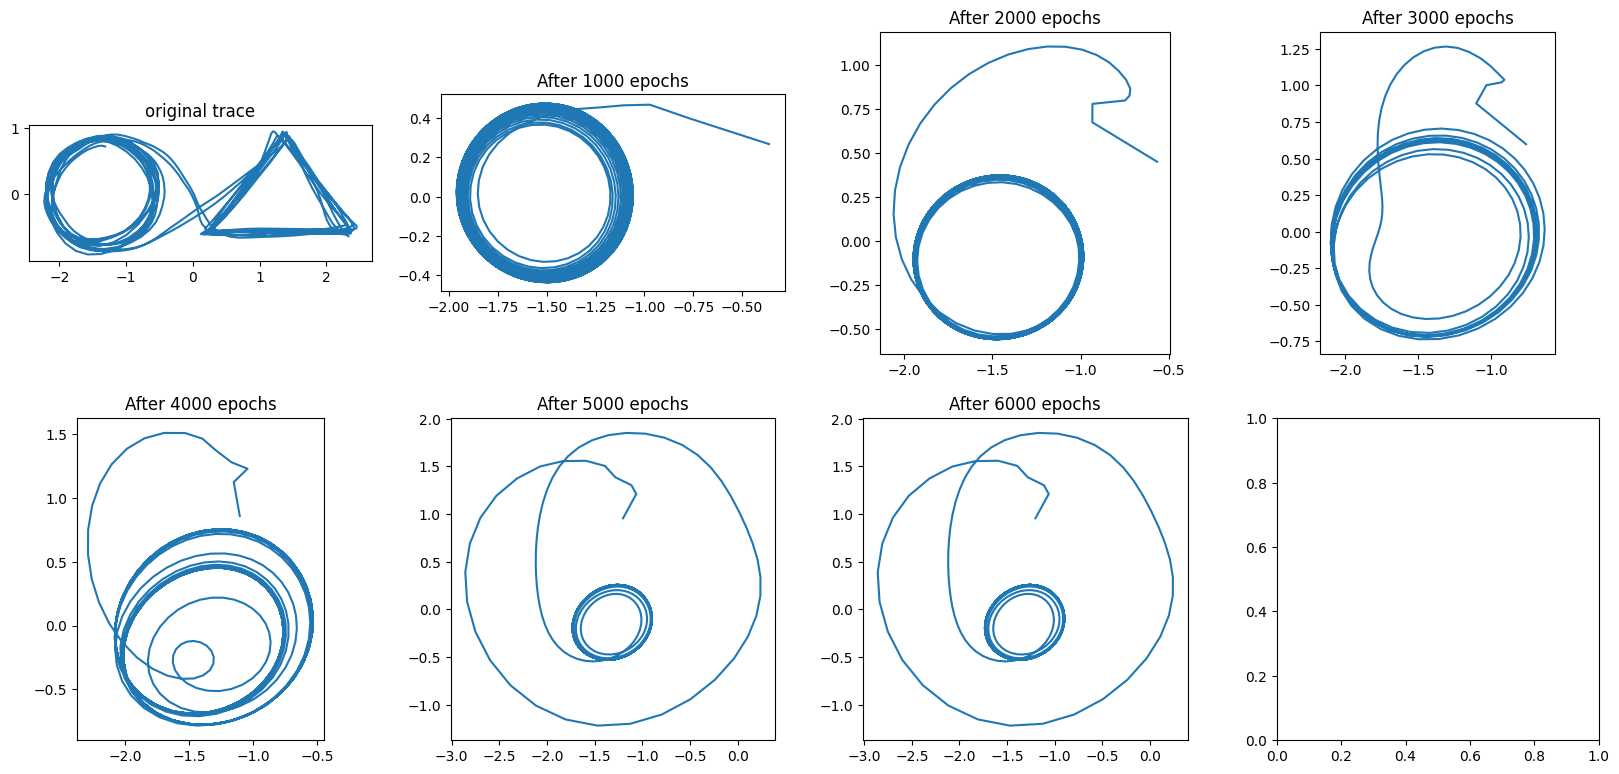

In [30]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5.1*n_cols,4.6*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates.cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

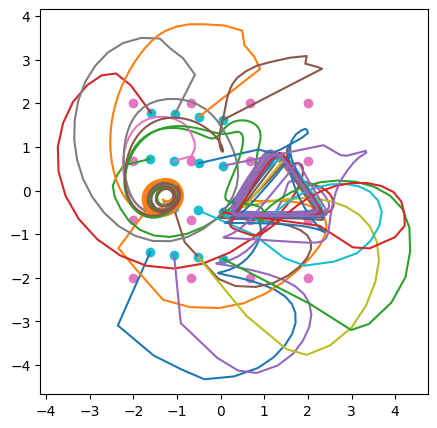

In [31]:
# plot a direction field
lim_x = 2. # largest magnitude of x
lim_y = 2.
N_x = 4 # number of points in x dimension
N_y = 4
n_points = 200
#df_fig = plt.figure(figsize = (10,10))
fig = plt.figure(figsize=(5,5))
plt.xlim(-1.1*lim_x, 1.1*lim_x)
plt.ylim(-1.1*lim_y, 1.1*lim_y)
plt.axis('equal')
for x in np.linspace(-lim_x, lim_x, N_x):
    for y in np.linspace(-lim_y, lim_y, N_y):
        #print(f"x = {x}, y = {y}")
        plt.scatter([x], [y], color='tab:pink')
        coordinate = torch.tensor([x, y], dtype=torch.float32).unsqueeze(dim=0)
        trajectory = generate_trajectory(coordinate, n_points)
        plt.scatter([trajectory[0, 0]], [trajectory[0,1]], color='tab:cyan')
        plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()

## LSTM Comparison

In [47]:
# Same thing, but using LSTM
# Create the network, the optimizer, and the loss function
input_size = 2  # this shouldn't change
hidden_size = 256
lr = 3e-4  # learning rate
all_generated = []

torch.manual_seed(345)

class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x, h0=None, c0=None):
        if h0 is None:
            h0 =  torch.zeros((1, hidden_size))
        if c0 is None:
            c0 =  torch.zeros((1, hidden_size))
        out, (h, c) = self.lstm(x, (h0, c0))
        return self.fc(out), h, c

# rnn = ElmanRNN(input_size, hidden_size, nonlinearity)
rnn = LSTM_RNN(input_size, hidden_size)

optim = torch.optim.Adam(rnn.parameters(), lr=lr)

loss = nn.MSELoss(reduction='mean')

In [57]:
# training loop
n_epochs = 1000  # number of epochs

for epoch in range(n_epochs):
    optim.zero_grad()
    out, _, _  = rnn(coordinates[:-1])
    error = loss(out, coordinates[1:])
    error.backward()
    optim.step()
    if epoch % 20 == 0:
        print(f"Error at epoch {epoch} = {error}")

Error at epoch 0 = 0.002488028025254607
Error at epoch 20 = 0.0011010555317625403
Error at epoch 40 = 0.0010563167743384838
Error at epoch 60 = 0.0010279525304213166
Error at epoch 80 = 0.0010105143301188946
Error at epoch 100 = 0.0011608580825850368
Error at epoch 120 = 0.0010572695173323154
Error at epoch 140 = 0.0009828399633988738
Error at epoch 160 = 0.0009662046213634312
Error at epoch 180 = 0.0009517158614471555
Error at epoch 200 = 0.00116038229316473
Error at epoch 220 = 0.0009687527781352401
Error at epoch 240 = 0.0009284960106015205
Error at epoch 260 = 0.001262356643564999
Error at epoch 280 = 0.0009218669729307294
Error at epoch 300 = 0.0008996632532216609
Error at epoch 320 = 0.0011333556612953544
Error at epoch 340 = 0.0008727047825232148
Error at epoch 360 = 0.0009133879211731255
Error at epoch 380 = 0.0011682857293635607
Error at epoch 400 = 0.001010160194709897
Error at epoch 420 = 0.0008578998385928571
Error at epoch 440 = 0.0008278957102447748
Error at epoch 460 = 0

In [53]:
# Generate a trajectory
n_points = 1000
coordinate = torch.tensor([-1, 1], dtype=torch.float32)
#coordinate = coordinates[0]
coordinate = coordinate.unsqueeze(dim=0)

def generate_trajectory(init_coordinate, n_points):
    gen_coordinates = np.empty((n_points, 2))
    coordinate = init_coordinate
    h = torch.zeros((1, hidden_size))
    c = torch.zeros((1, hidden_size))
    with torch.no_grad():
        for point_idx in range(n_points):
            coordinate, h, c = rnn(coordinate, h, c)
            gen_coordinates[point_idx, :] = coordinate.detach().numpy()
    return gen_coordinates

gen_coordinates = generate_trajectory(coordinate, n_points)
all_generated.append(gen_coordinates)

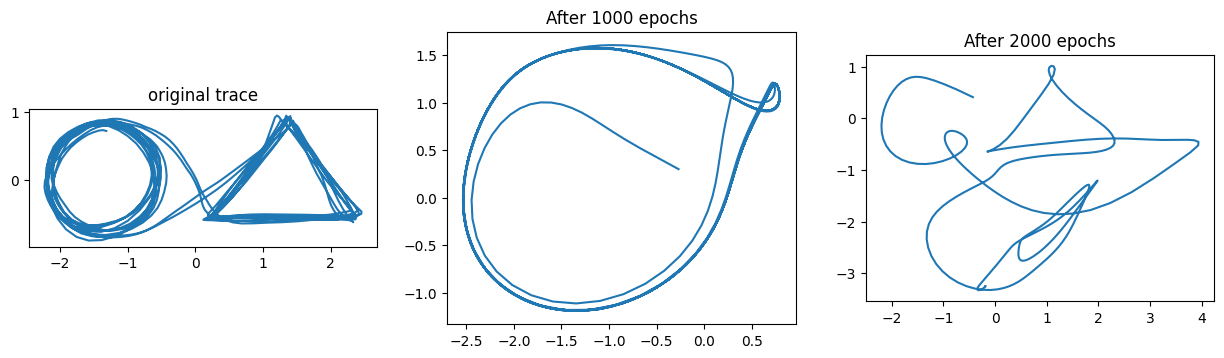

In [54]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5.1*n_cols,4.6*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates.cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

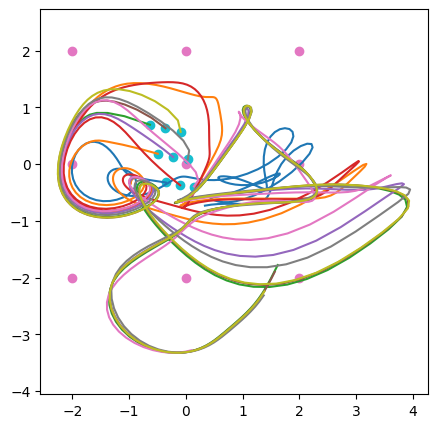

In [56]:
# plot a direction field
lim_x = 2. # largest magnitude of x
lim_y = 2.
N_x = 3 # number of points in x dimension
N_y = 3
n_points = 200
#df_fig = plt.figure(figsize = (10,10))
fig = plt.figure(figsize=(5,5))
plt.xlim(-1.1*lim_x, 1.1*lim_x)
plt.ylim(-1.1*lim_y, 1.1*lim_y)
plt.axis('equal')
for x in np.linspace(-lim_x, lim_x, N_x):
    for y in np.linspace(-lim_y, lim_y, N_y):
        #print(f"x = {x}, y = {y}")
        plt.scatter([x], [y], color='tab:pink')
        coordinate = torch.tensor([x, y], dtype=torch.float32).unsqueeze(dim=0)
        trajectory = generate_trajectory(coordinate, n_points)
        plt.scatter([trajectory[0, 0]], [trajectory[0,1]], color='tab:cyan')
        plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()